# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.health import BMI, bmi_str_to_label
from utils.age import AgeLevel, age_str_to_label
from utils.stats import detect_outliers, spearman_corr, kruskal_wallis_test, ModelEvaluator
from utils.plots import create_grouped_boxplots, plot_feature_importance, plot_corr_ellipses, plot_catboost_learning_curve
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder
from scipy.stats import spearmanr
# Palette of colors used for the plots
# and displaying all columns in pandas
red  = '#BE3232'
blue = '#2D4471'

# Data Collection and Exploration

In [2]:
train = pd.read_excel('assets/train.xlsx', sheet_name='MODELAGEM')
test = pd.read_excel('assets/test.xlsx')

## Data Structure

In [3]:
train.shape, test.shape

((1211, 12), (127, 12))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   MATRICULA   1211 non-null   int64         
 1   IDADE       1206 non-null   float64       
 2   NASCIMENTO  1203 non-null   datetime64[ns]
 3   SEXO        1204 non-null   object        
 4   IMC         1206 non-null   float64       
 5   FILHOS      1203 non-null   float64       
 6   FUMANTE     1203 non-null   float64       
 7   SIGNO       1205 non-null   object        
 8   REGIÃO      1205 non-null   float64       
 9   FACEBOOK    1208 non-null   float64       
 10  CLASSE      1206 non-null   float64       
 11  VALOR       1211 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 113.7+ KB


## Missing Values

Check for missing values to understand the completeness of the dataset

In [5]:
train.isna().sum()

MATRICULA     0
IDADE         5
NASCIMENTO    8
SEXO          7
IMC           5
FILHOS        8
FUMANTE       8
SIGNO         6
REGIÃO        6
FACEBOOK      3
CLASSE        5
VALOR         0
dtype: int64

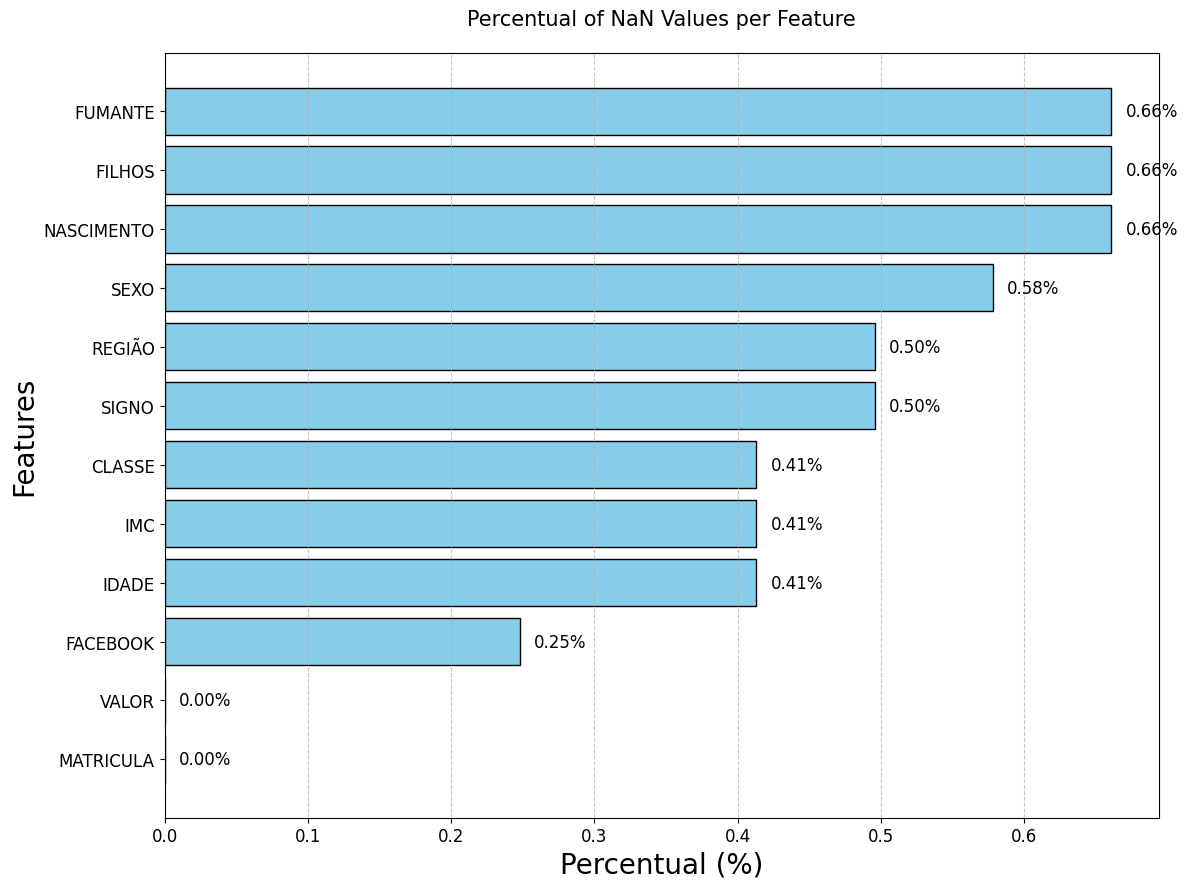

In [6]:
nan_percentual = (train.isna().sum() / len(train) * 100).sort_values(ascending=True)
plt.figure(figsize=(12, 9))
plt.barh(range(len(nan_percentual)), nan_percentual, edgecolor="black", color="skyblue")
plt.title("Percentual of NaN Values per Feature", pad=20, fontsize=15)
plt.xlabel("Percentual (%)", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.yticks(range(len(nan_percentual)), nan_percentual.index, fontsize=12)
plt.xticks(fontsize=12)
for i, v in enumerate(nan_percentual):
    plt.text(v + 0.01, i, f"{v:.2f}%", va="center", color="black", size=12)
plt.tight_layout()
plt.grid(True, axis="x", linestyle="--", alpha=0.7)
plt.show()

Based on the graph analysis, we can say that dropping `NaN` values would be an appropriate strategy in this case, for several reasons:

 * _Very low percentages_: All features show extremely low percentages of missing values, ranging from 0% to 0.66%. This means that when dropping rows with NaN, you would lose a minimal amount of data.

 * _Data integrity preservation_: With such low percentages, you would maintain more than 99% of your original data even when choosing the most conservative approach of complete row removal

## Unique Values

In [7]:
train.nunique()

MATRICULA     1211
IDADE           47
NASCIMENTO    1162
SEXO             2
IMC            525
FILHOS           6
FUMANTE          2
SIGNO           12
REGIÃO           4
FACEBOOK         2
CLASSE          10
VALOR         1207
dtype: int64

The data shows that 

* Categorical Variables: `SEXO`, `FUMANTE`, `SIGNO`, `REGIÃO`, `FACEBOOK`,`CLASSE`
* Numerical Variables: `IDADE`, `IMC`, `FILHOS`, `VALOR`

## Feature Engineering

Body Mass Index (BMI or IMC in Portuguese) is a widely used metric to assess an individual's body weight relative to their height. It is calculated by dividing a person’s weight in kilograms by the square of their height in meters:

$$IMC = \frac{weight}{height^2}$$
​
 
The World Health Organization (WHO) has established a classification system to interpret BMI values. These categories provide a general indication of whether an individual is underweight, has a normal weight, or is overweight, as well as identifying various levels of obesity.

Here are the BMI ranges and their respective classifications:

* Severely Underweight (BMI ≤ 16.9):
Individuals in this range may experience serious health risks due to malnutrition and a weakened immune system.

* Underweight (BMI 17.0 - 18.4):
Being underweight may indicate insufficient caloric intake or underlying health issues that require attention.

* Normal Weight (BMI 18.5 - 24.9):
This range is considered healthy and indicates a balanced body weight relative to height. Maintaining this BMI reduces the risk of weight-related health issues.

* Overweight (BMI 25.0 - 29.9):
Individuals in this range may have an increased risk of developing cardiovascular diseases, type 2 diabetes, and other health concerns.

* Obesity Level 1 (BMI 30.0 - 34.9):
This category represents moderate obesity and is associated with a higher risk of metabolic syndrome and other chronic conditions.

* Obesity Level 2 (BMI 35.0 - 40.0):
This range indicates severe obesity, which significantly increases the likelihood of serious health problems, including hypertension and heart disease.

* Obesity Level 3 (BMI ≥ 40.1):
Also referred to as morbid obesity, individuals in this category face the highest risk of life-threatening conditions and may require medical intervention.

In [8]:
train['imc_class'] = train['IMC'].apply(lambda x: BMI(value=x).category if x >= 0 else None)
train['imc_label'] = train['imc_class'].apply(lambda x: bmi_str_to_label(x) if x else None)

train['age_class'] = train['IDADE'].apply(lambda x: AgeLevel(value=x).category if x >= 0 else None)
train['age_label'] = train['age_class'].apply(lambda x: age_str_to_label(x) if x else None)

## Univariate Analysis

Let us start by analyzing the target variable: `VALOR`, which is the value of the health insurance plan. The idea is to understand the distribution of this variable and check if there are any outliers. To outliers detection, we will use the IQR method, whihc in turn
is based on the 25th and 75th percentiles of the data. The IQR is calculated as the difference between the 75th and 25th percentiles.


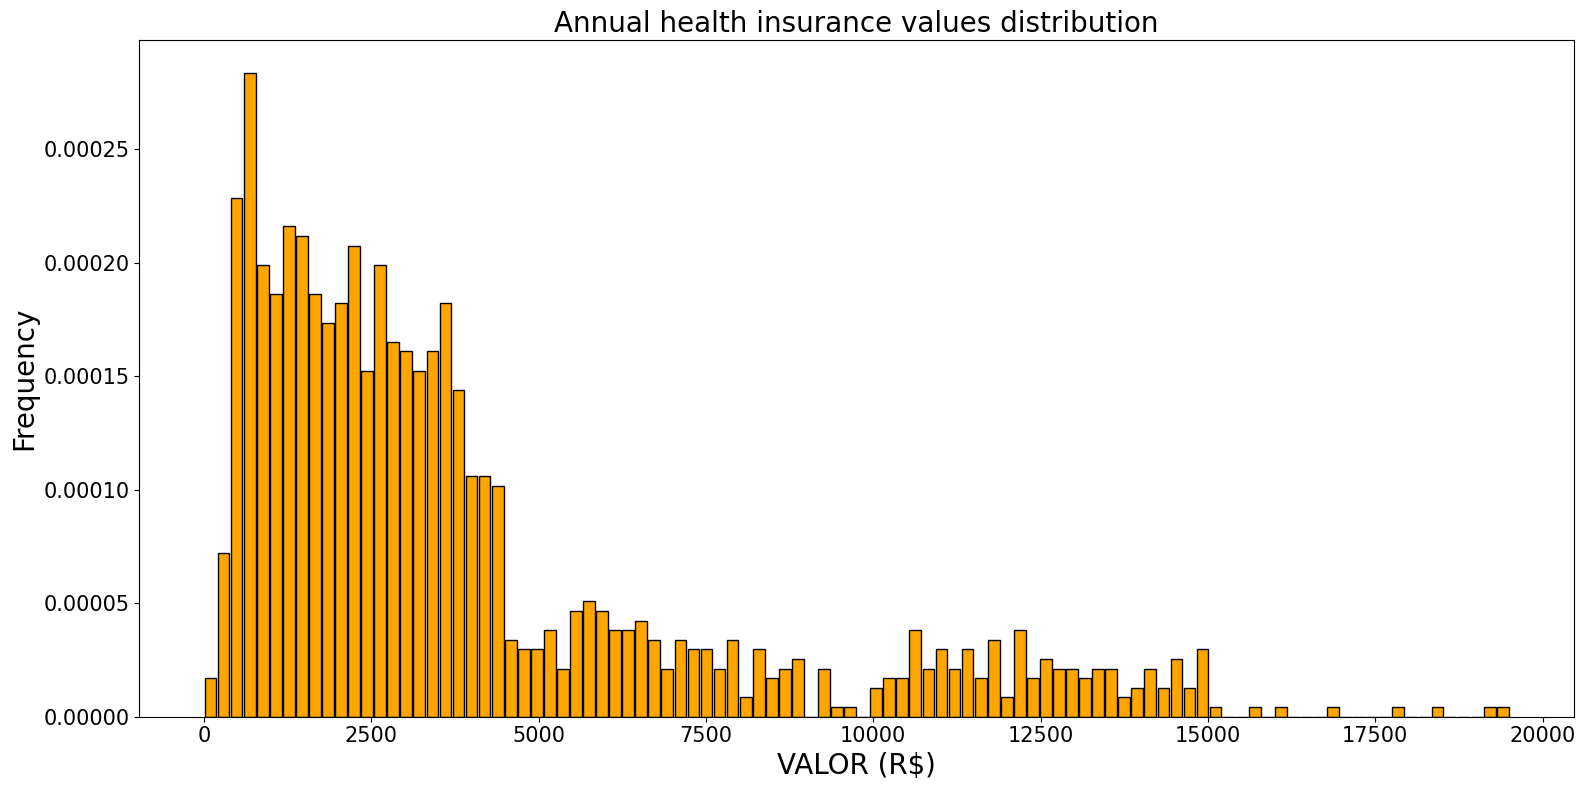

In [9]:
fig, ax = plt.subplots(figsize=(16,8))
plt.hist(train['VALOR'], bins=100, color="orange", rwidth=0.9, edgecolor='black', density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('VALOR (R$)', fontsize=20)
plt.title('Annual health insurance values distribution', fontsize=20)
fig.tight_layout()

Analyzing this distribution graph of annual health insurance values, we can identify several important points:

1. Right (positive) skewness:
* The distribution is clearly asymmetric with a long right tail
* Most values are concentrated between 0 and 5000 (lower values)
* There are some values reaching close to 20000 (outliers or premium plans)

2. For analysis:
* It would be important to investigate if higher values are associated with specific characteristics (age, IMC, customer segmentation, etc.)


In [10]:
outliers = detect_outliers(train['VALOR'])

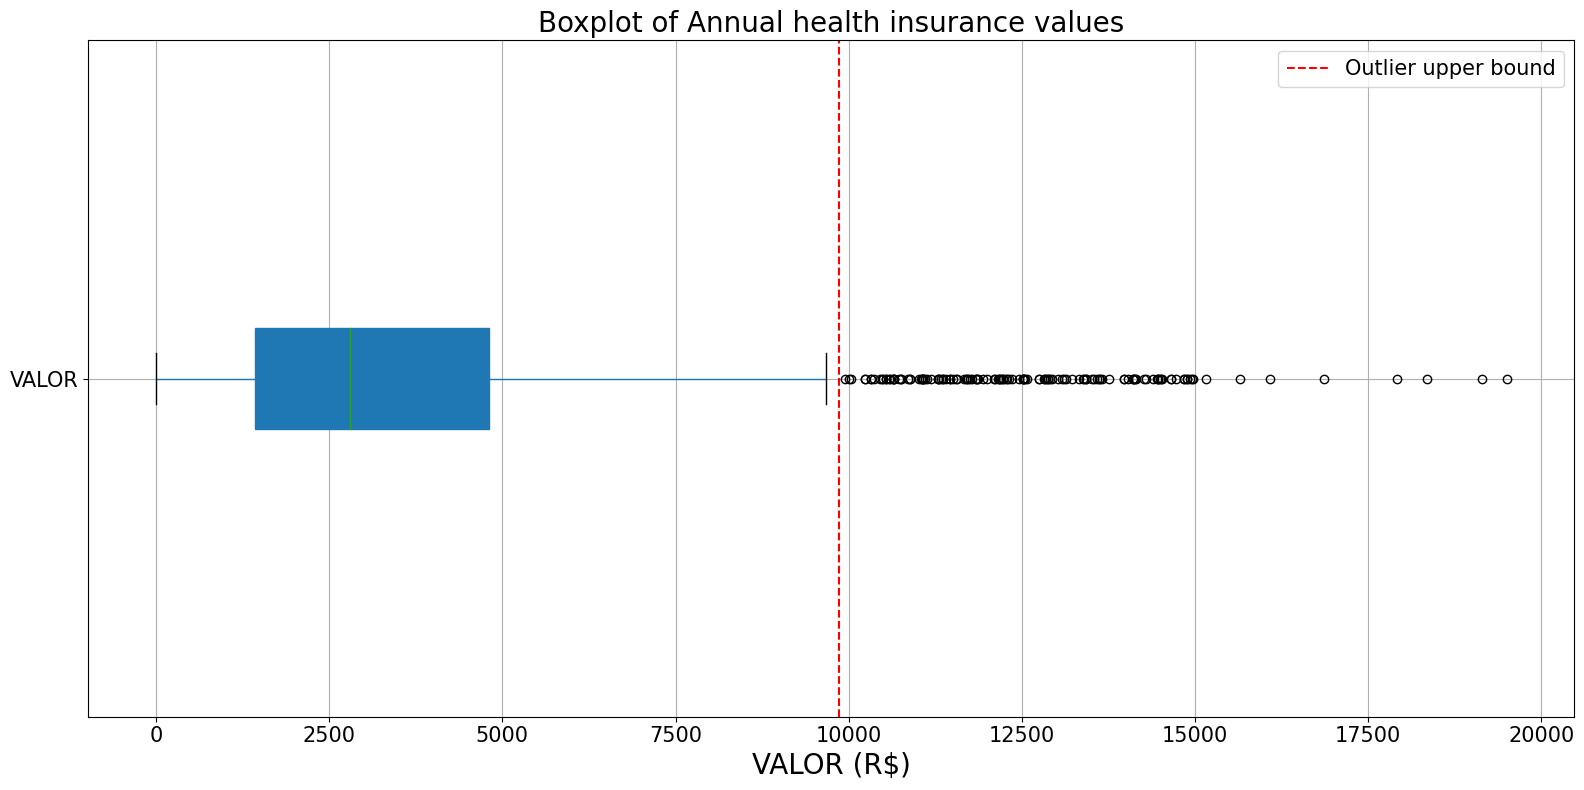

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
train.boxplot(column='VALOR', ax=ax, vert=False, patch_artist=True, meanline=True)
plt.xticks(fontsize=15)
plt.xlabel('VALOR (R$)', fontsize=20)
plt.axvline(outliers['upper_bound'], color='red', linestyle='--', label='Outlier upper bound')
plt.yticks(fontsize=15)
plt.title('Boxplot of Annual health insurance values', fontsize=20)
plt.legend(fontsize=15)
fig.tight_layout()
plt.show()

In [12]:
train["VALOR"].describe().to_frame()

,VALOR
count,1211.000000
mean,4004.364655
std,3708.175745
min,0.000000
25%,1433.361728
50%,2795.397859
75%,4805.837775
max,19501.659942


### Understanding the outliers

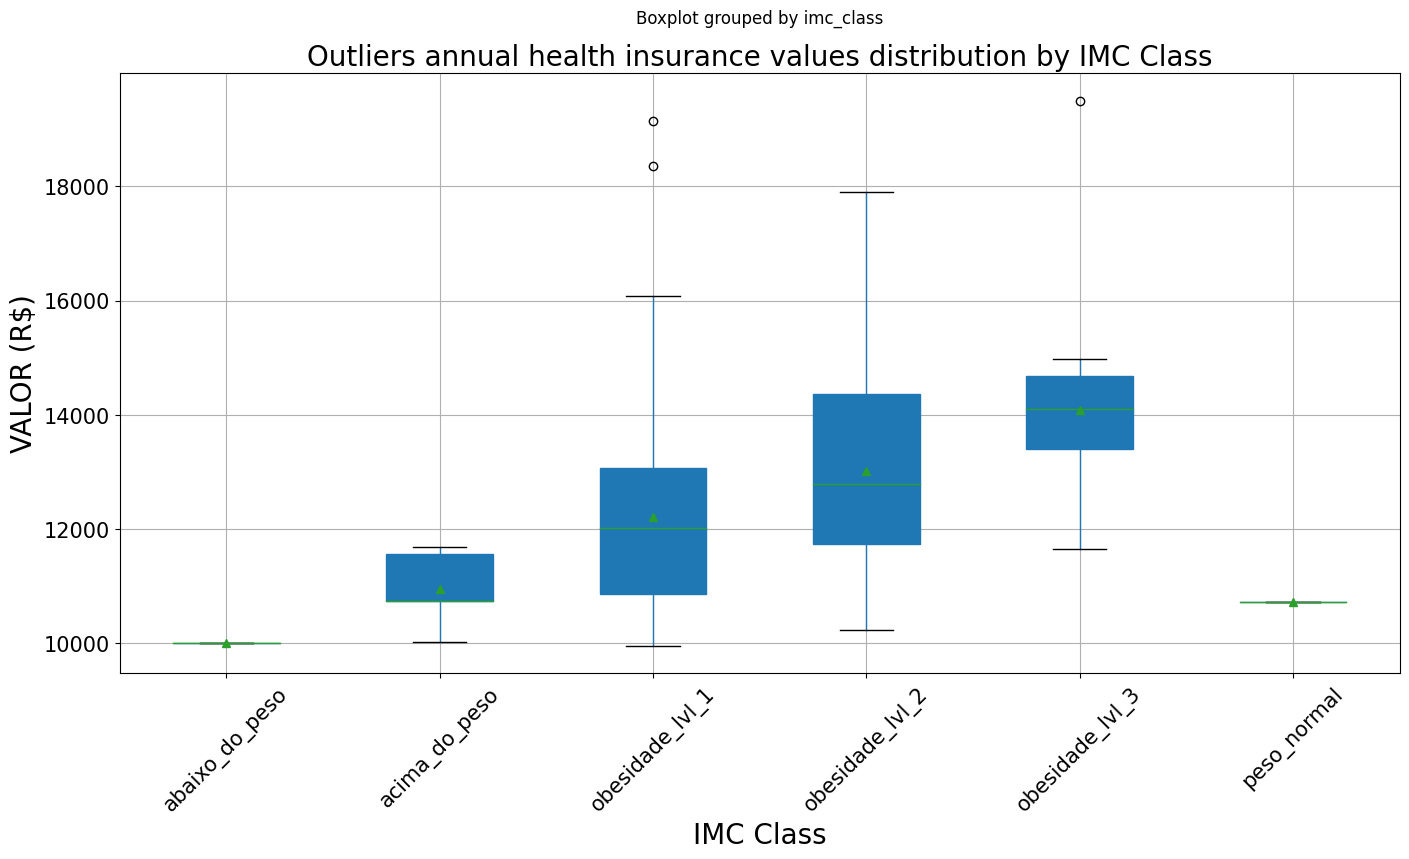

In [13]:
box_data = train[train['VALOR'] > outliers['upper_bound']]
box_data = box_data[~box_data['imc_class'].isnull()]
box_data.boxplot(column='VALOR', by='imc_class', figsize=(16, 8), vert=True, patch_artist=True, showmeans=True)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('VALOR (R$)', fontsize=20)
plt.xlabel('IMC Class', fontsize=20)
plt.title('Outliers annual health insurance values distribution by IMC Class', fontsize=20)
plt.show()

The chart above shows the distribution of highest annual health insurance values for each IMC class. We can see that the outliers are concentrated in the "Obese" class.

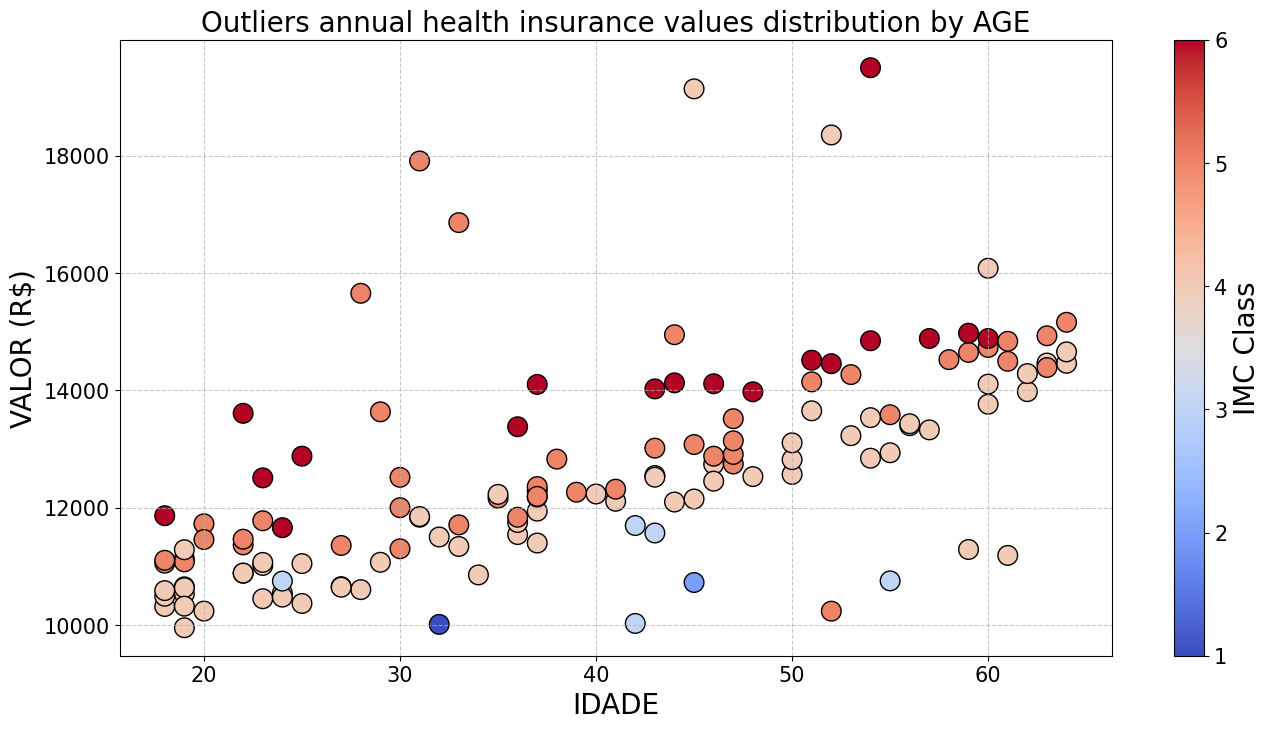

In [14]:
plt.figure(figsize=(16, 8))
scatter = plt.scatter(
    x=train[train['VALOR'] > outliers['upper_bound']]['IDADE'],
    y=train[train['VALOR'] > outliers['upper_bound']]['VALOR'],
    c=train[train['VALOR'] > outliers['upper_bound']]['imc_label'],
    cmap='coolwarm',
    edgecolors='black',
    s=200
)
cbar = plt.colorbar(scatter, label='IMC Category')
cbar.ax.tick_params(labelsize=15)
cbar.set_label('IMC Class', fontsize=20)
plt.xlabel('IDADE', fontsize=20)
plt.ylabel('VALOR (R$)', fontsize=20)
plt.title('Outliers annual health insurance values distribution by AGE', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Health insurance costs tend to increase with age, showing a rising trend on the VALOR feature. The outliers are mostly in the overweight and obese categories, which is expected since these categories are more likely to have health problems that require more medical care.

(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'center': 'Outliers annual health insurance values distribution by Age Label and IMC Class'}, xlabel='age_label', ylabel='VALOR'>)

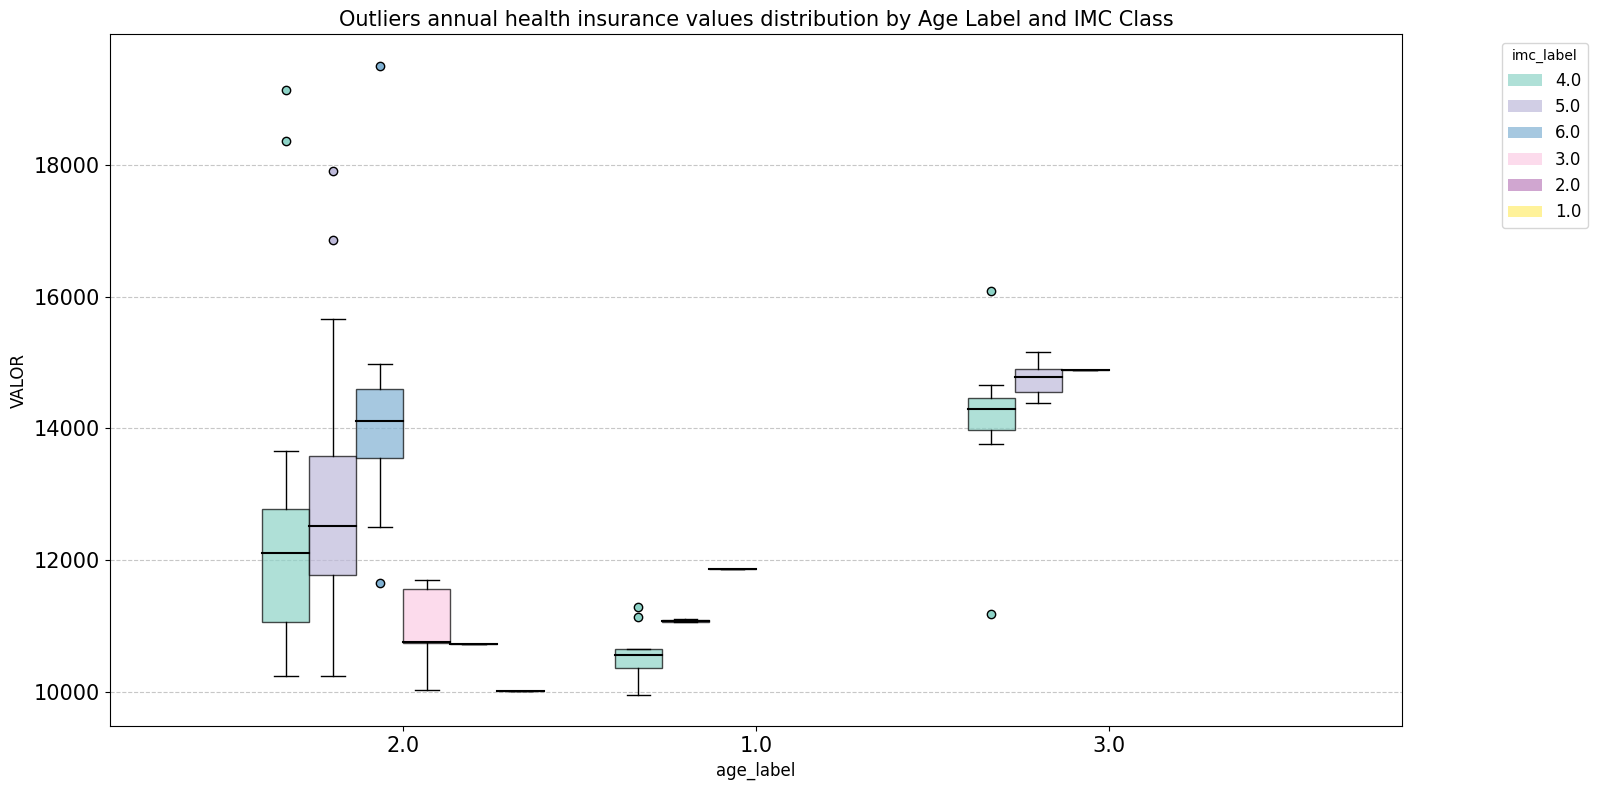

In [15]:
create_grouped_boxplots(
  df=train[train['VALOR'] > outliers['upper_bound']].dropna(subset=['age_label']),
  x_column='age_label',
  y_column='VALOR',
  hue_column='imc_label',
  title='Outliers annual health insurance values distribution by Age Label and IMC Class',
  figsize=(16, 8),
  show_means=False
)

Customers that belong to the groups 2 (20 - 59 years old) and 3 (greater than 60 years old) have higher annual health insurance values and also higher levels of Obesity.

(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'center': 'Outliers annual health insurance values distribution by Children and IMC Class'}, xlabel='FILHOS', ylabel='VALOR'>)

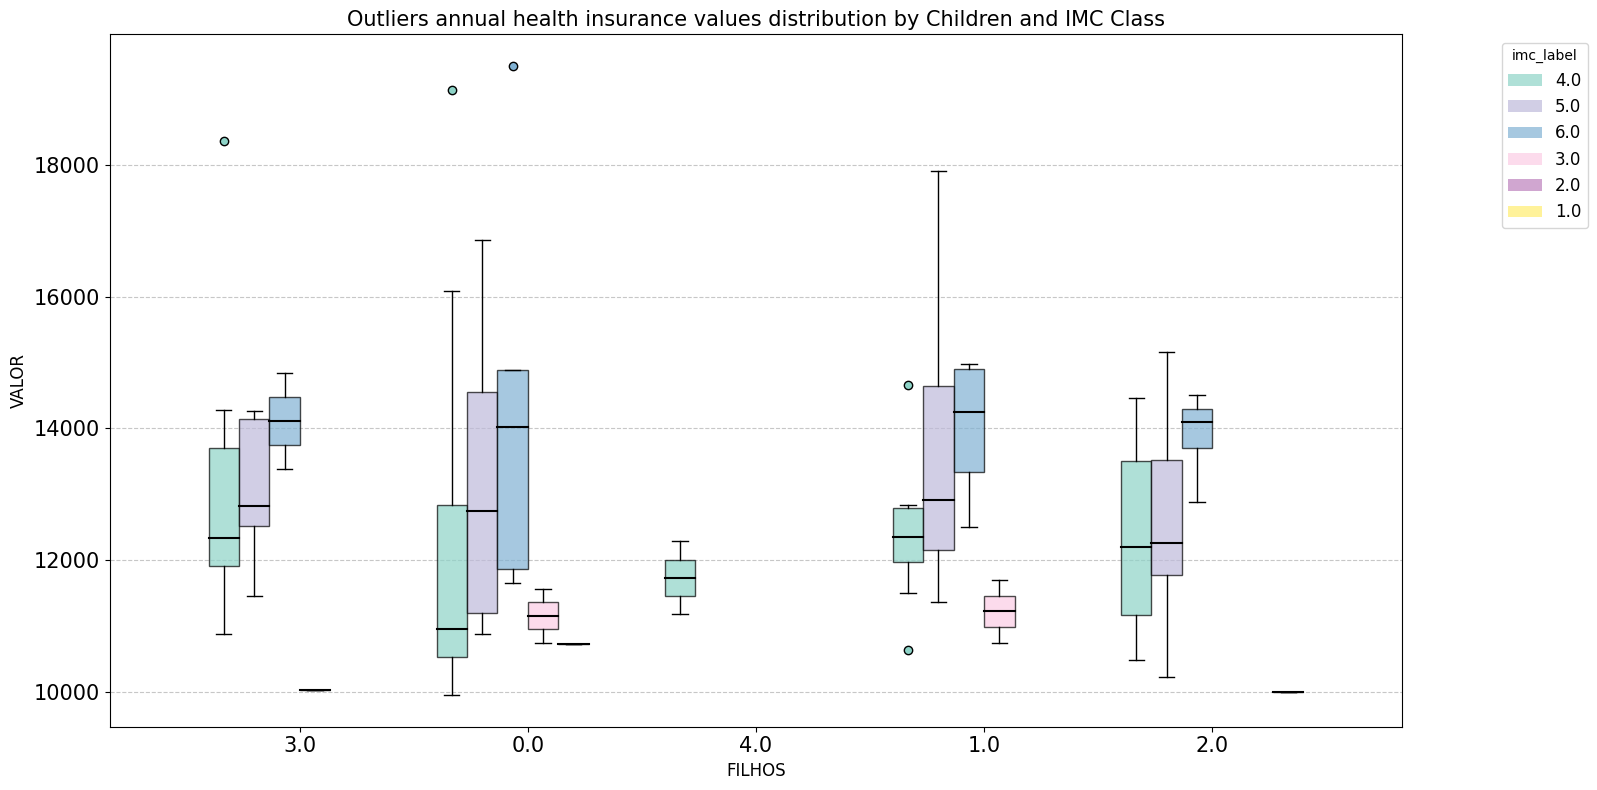

In [16]:
create_grouped_boxplots(
  df=train[train['VALOR'] > outliers['upper_bound']],
  x_column='FILHOS',
  y_column='VALOR',
  hue_column='imc_label',
  title='Outliers annual health insurance values distribution by Children and IMC Class',
  figsize=(16, 8),
  show_means=False
)

The chart shows that the annual health insurance values of outliers increases for people with children and higher IMC classes.

(<Figure size 1600x800 with 1 Axes>,
 <Axes: title={'center': 'Outliers annual health insurance values distribution by Smoke (Y/N) and IMC Class'}, xlabel='FUMANTE', ylabel='VALOR'>)

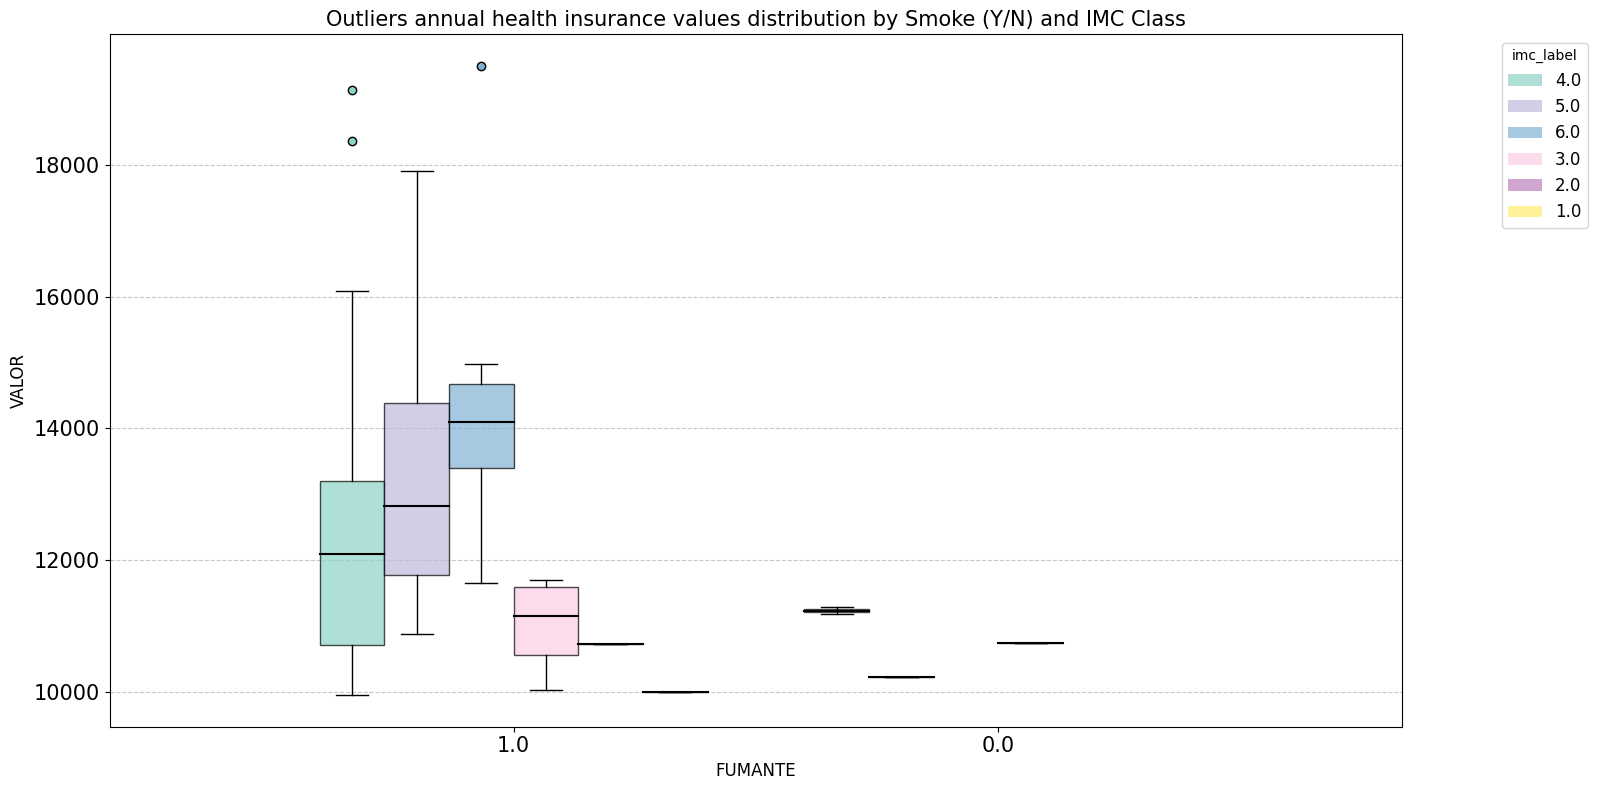

In [17]:
create_grouped_boxplots(
  df=train[train['VALOR'] > outliers['upper_bound']].dropna(subset=['FUMANTE']),
  x_column='FUMANTE',
  y_column='VALOR',
  hue_column='imc_label',
  title='Outliers annual health insurance values distribution by Smoke (Y/N) and IMC Class',
  figsize=(16, 8),
  show_means=False
)

* Smokers (1.0):

Insurance values are significantly higher for smokers.

* Non-smokers (0.0):

Insurance values are considerably lower.
The distribution is more compact, indicating less variability.

Summary of Outliers Analysis:

- The anual healthy insurance values are high for this group since they belongs to high level of Obesity.
- The values increases with age and high level of Obesity.
- The values are high for people with children and high level of Obesity.
- The values are high for people who smoke

Based on that we will not discart the outlires from dataset.

## Feature Importance

*Mutual information* (MI) is a measure of the dependence between two random variables. It quantifies the amount of information that one random variable contains about the other.

Formally, the mutual information between two random variables $X$ and $Y$ is defined as:

$$I(X;Y) = \sum_{x \in \mathcal{X}} \sum_{y \in \mathcal{Y}} p(x,y) \log \frac{p(x,y)}{p(x)p(y)}$$

where $\mathcal{X}$ and $\mathcal{Y}$ are the state spaces of the variables $X$ and $Y$, respectively, and $p(x,y)$ is the joint probability of the variables $X$ and $Y$ taking on the values $x$ and $y$, respectively.

MI is a non-negative measure that takes on a maximum value of 1 when the variables $X$ and $Y$ are perfectly dependent. In the case of independence, the mutual information is equal to 0.

Let us compare the MI of the features with the target `VALOR`

In [18]:
label_encoder = LabelEncoder()

train['signo_encoded'] = label_encoder.fit_transform(train['SIGNO'])
train['sex_label'] = train['SEXO'].apply(lambda x: 0 if x == 'M' else 1)

In [19]:
train_clean = train.dropna()

Y = train_clean['VALOR'].values
X = train_clean.drop(['MATRICULA', 'NASCIMENTO', 'VALOR', 'SEXO', 'SIGNO', 'imc_class', 'age_class'], axis=1)

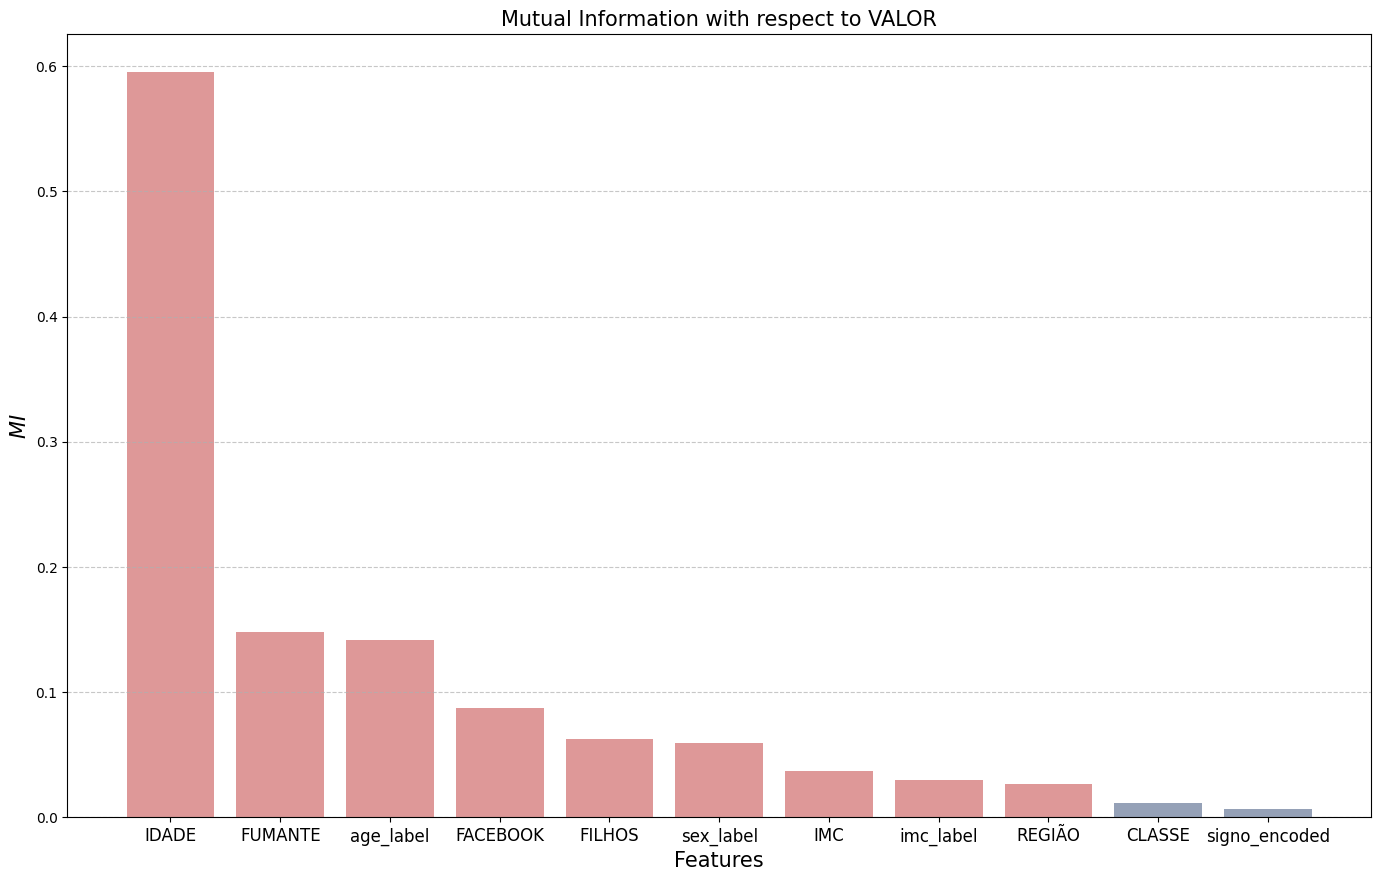

Best correlated features:
 ['IDADE', 'FUMANTE', 'age_label', 'FACEBOOK', 'FILHOS', 'sex_label', 'IMC', 'imc_label', 'REGIÃO']


In [20]:
mi_values = mutual_info_regression(X, Y, discrete_features=False)
mi_norm = np.log(len(mi_values))
mi_column = pd.DataFrame(mi_values/mi_norm, index=pd.Index(X.columns, name='features'), 
                         columns=['features_MI'])

mi_column = mi_column.sort_values(by='features_MI', ascending=False)

# Convert the index 'Features' into a column for plotting
mi_column_reset = mi_column.reset_index()

# Plotting
feature_threshold= 0.020
fig, ax = plt.subplots(figsize=(15, 10))
plot_feature_importance(mi_column_reset, x='features', y='features_MI', ax=ax, threshold=feature_threshold, 
                        title="Mutual Information with respect to VALOR", xlabel="Features", 
                        ylabel="$MI$", palette=[blue, red])

plt.show()

# Select features with MI > feature_threshold
best_mi_features = list(mi_column[mi_column['features_MI'] > feature_threshold].index)
print("Best correlated features:\n",best_mi_features)

Although some features are important from a business perspective and provide valuable insights, from a predictive standpoint, we need to evaluate their predictive power. Based on the mutual information (MI) values, we have the following observations:

* **`IDADE` (Age):**  
  This feature has the highest MI value, around 0.6, indicating that age is the most informative feature for predicting the target (`VALOR`). This aligns with expectations, as insurance costs are often strongly correlated with age due to increasing health risks.

* **`FUMANTE` (Smoker):**  
  The second most informative feature, with an MI value of approximately 0.15. Smoking is a strong predictor of higher insurance costs, reflecting the health risks associated with the habit.

* **`age_label`:**  
  This derived feature (likely categorical age bins) also demonstrates high MI, comparable to `FUMANTE`. This suggests that engineered features based on `IDADE` can be nearly as predictive as the original continuous variable.

* **`FACEBOOK`, `FILHOS`, and `sex_label`:**  
  These features provide moderate levels of information:  
  - `FACEBOOK` may capture behavioral or lifestyle traits that influence insurance costs.  
  - `FILHOS` and `sex_label` likely relate to familial or gender-based trends affecting health insurance costs.

* **`IMC`, `imc_label`, and `REGIÃO`:**  
  Despite their relevance to health risks, these features show lower MI values compared to others. For instance:  
  - `IMC` (BMI) alone may not significantly influence costs in this dataset.  
  - Similarly, `REGIÃO` (region) appears to have a minimal effect on insurance costs, suggesting location does not play a major role.

* **`CLASSE` and `signo_encoded`:**  
  These features have minimal impact on the target variable. Notably, `signo_encoded` has the lowest MI value, indicating it is largely irrelevant for predicting `VALOR`.

## Correlation Analysis

Correlation analysis helps assess the relationship between variables, but the approach varies depending on the type of features being analyzed:

* **Numerical Features**: For continuous numerical features, correlation metrics like Pearson's or Spearman's correlation coefficients are commonly used. Pearson measures linear relationships, while Spearman assesses monotonic relationships, making it suitable for non-linear data.

* **Ordinal Features**: These are categorical variables with an inherent order (e.g., low, medium, high). Spearman’s rank correlation is particularly useful here, as it respects the ordering of the data without assuming equal intervals between categories.

* **Nominal Features**: For categorical variables without order (e.g., colors, brands), traditional correlation metrics are not suitable. For relationships between nominal and numerical features, ANOVA (assuming gaussianity) or Kruskall-Wallis for non gaussianity.

### Numerical Features

In [21]:
numerical_features = [
    'IDADE', 
    'FILHOS', 
    'IMC' 
]

We will create a unique heatmap using ellipses to visualize the correlation between each feature more effectively. Specifically, we will use Spearman correlation for this analysis. The orientation of the ellipse indicates whether two variables are positively correlated (pointing to the top right) or negatively correlated (pointing to the top left). Additionally, the shading and width of the ellipse reflect the strength of the association: thinner and darker ellipses represent stronger relationships.

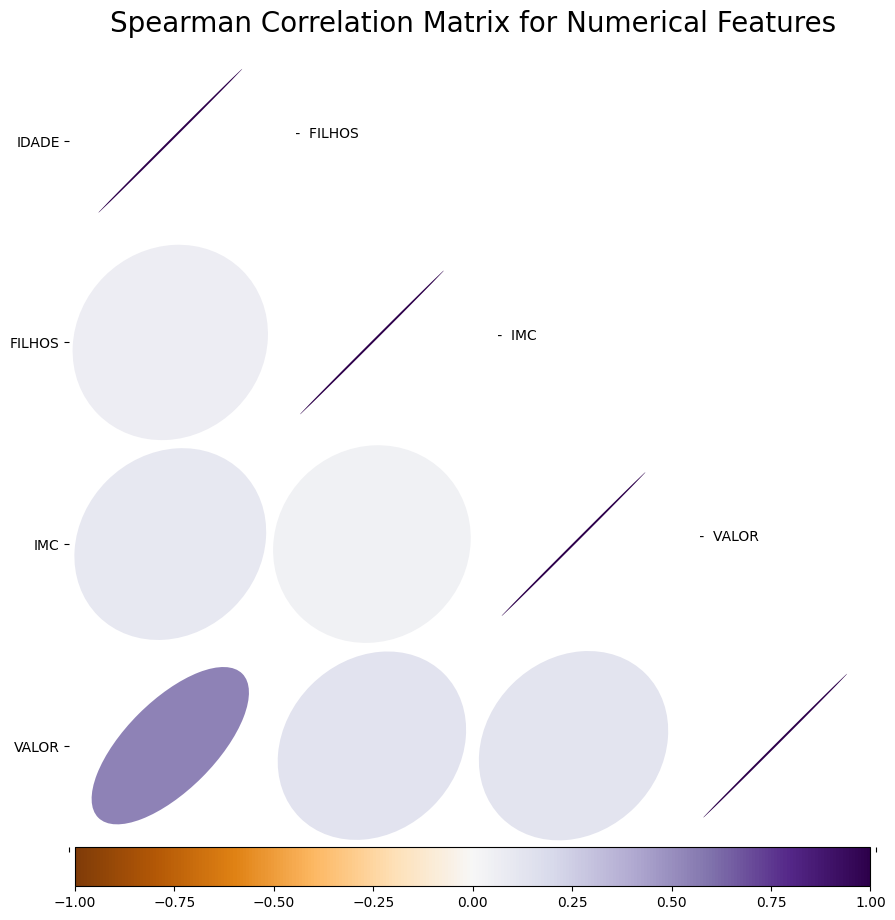

In [22]:
correlation_matrix = train_clean[numerical_features + ['VALOR']].corr(method='spearman')
# Use the function with the Spearman correlation matrix
ec, ax = plot_corr_ellipses(correlation_matrix, figsize=(20, 9), cmap='PuOr')
plt.tight_layout()
plt.title('Spearman Correlation Matrix for Numerical Features', fontsize=20)
plt.show()

Insights:

* **Age (`IDADE`)** and **Value (`VALOR`)**: The ellipse points slightly toward the top right, suggesting a stronger positive correlation between age and value.

* **Children (`FILHOS`)** and **Value (`VALOR`)**: The ellipse is narrower and points toward the top right, indicating a moderate positive correlation.

* **BMI (`IMC`)** and **Value (`VALOR`)**: The ellipse is narrower and points toward the top right, indicating a moderate positive correlation.


Let's use Pearson's correlation to evaluate whether there is a *linear* relationship between the numerical features and the target variable `VALOR`.

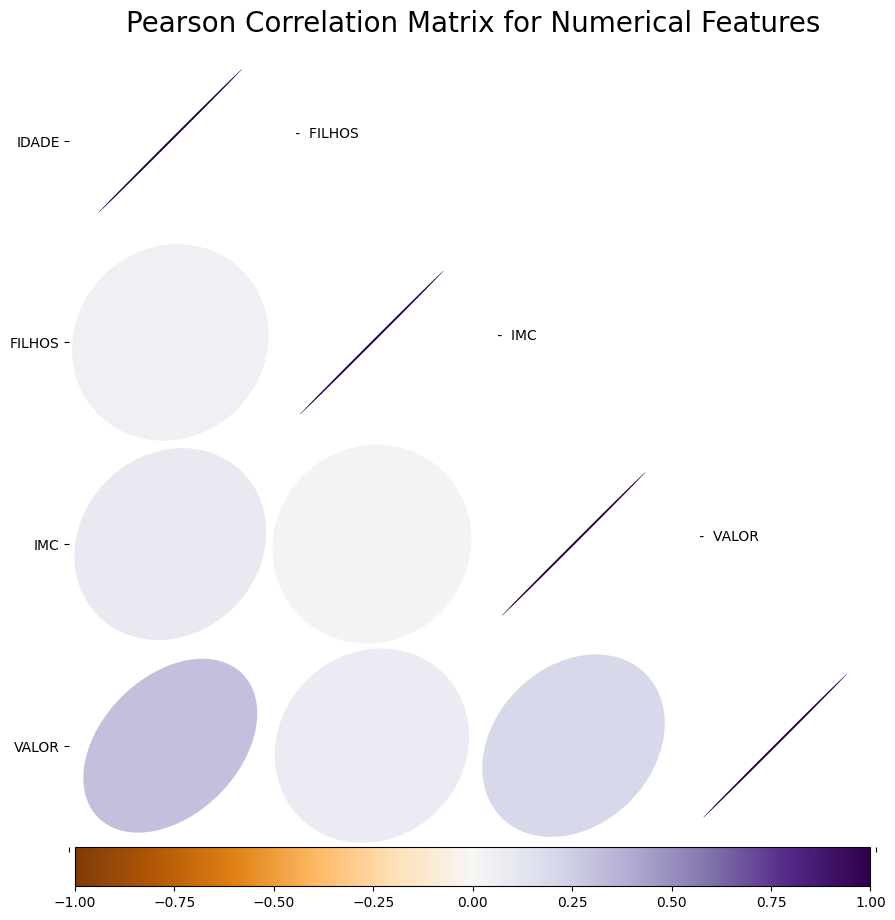

In [23]:
correlation_matrix = train_clean[numerical_features + ['VALOR']].corr(method='pearson')
# Use the function with the Spearman correlation matrix
ec, ax = plot_corr_ellipses(correlation_matrix, figsize=(20, 9), cmap='PuOr')
plt.tight_layout()
plt.title('Pearson Correlation Matrix for Numerical Features', fontsize=20)
plt.show()

Insigths: There is no strong linear relationship between numerical features and target variable `VALOR`.

## Categorical Ordinal

The features categorized as ordinal are `age_label` and `imc_label`. To gain a comprehensive understanding of the relationships between this feature and the target variable, namely `VALOR`, we will employ two methods:

* *Kruskal-Wallis (KW) Test*: This non-parametric test assesses whether there are statistical differences among the medians of distinct groups. The *null hypothesis* posits that these medians are equal.

* *Spearman Test*: This non-parametric statistical method is employed to analyze associations between two numerical variables. It is particularly suitable for determining if a monotonic association exists between them.

In [24]:
sp_values = pd.DataFrame([
    spearman_corr(
      X[feature], 
      Y
    ) for feature in ['age_label', 'imc_label']
],
index=['age_label', 'imc_label']
)

sp_values

,correlation,pvalue,significant
age_label,0.366517,3.381967e-38,True
imc_label,0.126202,1.625823e-05,True


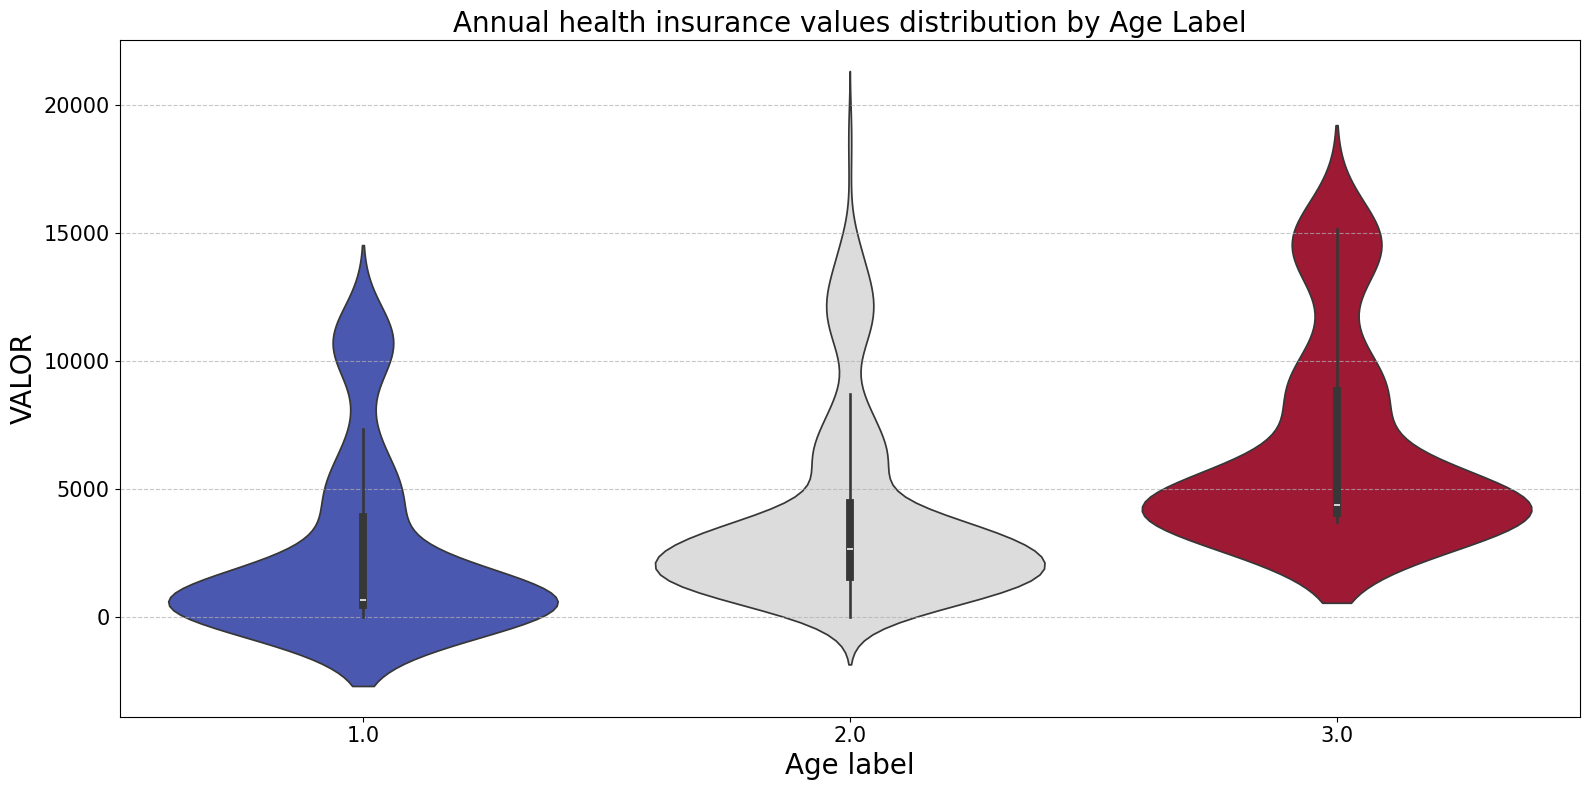

In [25]:
plt.figure(figsize=(16, 8))
sns.violinplot(x='age_label', y='VALOR', data=train_clean, palette='coolwarm', hue='age_label', legend=False)
plt.xlabel('Age label', fontsize=20)
plt.ylabel('VALOR', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Annual health insurance values distribution by Age Label', fontsize=20)
plt.tight_layout()
plt.show()

Insights: We observe a positive monotonic relationship between `age_label` and `VALOR`, as suggested by Spearman's correlation. As the `age_label` categories increase, there is a corresponding increase in `VALOR`.

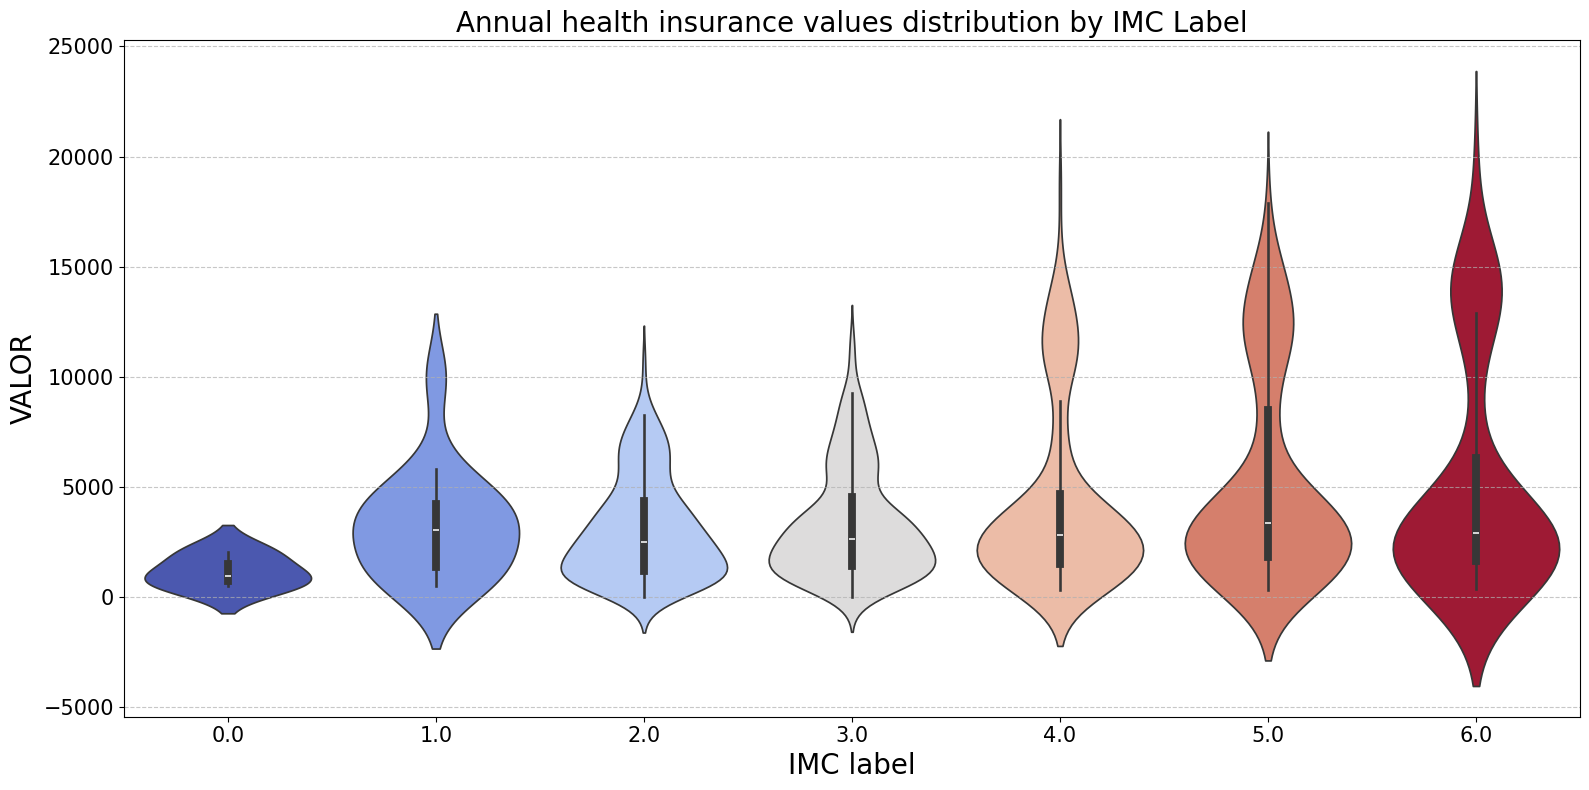

In [26]:
plt.figure(figsize=(16, 8))
sns.violinplot(x='imc_label', y='VALOR', data=train_clean, palette='coolwarm', hue='imc_label', legend=False)
plt.xlabel('IMC label', fontsize=20)
plt.ylabel('VALOR', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Annual health insurance values distribution by IMC Label', fontsize=20)
plt.tight_layout()
plt.show()

Insights: We see a weak positive monotonic relationship between the IMC label and the target variabel, `VALOR`.

### Categorical Nominal 

In [27]:
nominals = [
    'FUMANTE',
    'FACEBOOK',
    'sex_label',
    'REGIÃO'
]

In [28]:
kw_nominals = []
for category in nominals:
    kruskall_stats, kw_p_value = kruskal_wallis_test(train_clean, category, 'VALOR')
    kw = {
        'Category': category,
        'KW_Statistic': kruskall_stats,
        'P_Value': kw_p_value,
        'Significant': kw_p_value < 0.05
    }
    kw_nominals.append(kw)
    print(f"The result KW test between {category} and VALOR is: {kw['Significant']}")

kw_nominals_dataframe = pd.DataFrame(kw_nominals)

The result KW test between FUMANTE and VALOR is: True
The result KW test between FACEBOOK and VALOR is: True
The result KW test between sex_label and VALOR is: False
The result KW test between REGIÃO and VALOR is: False


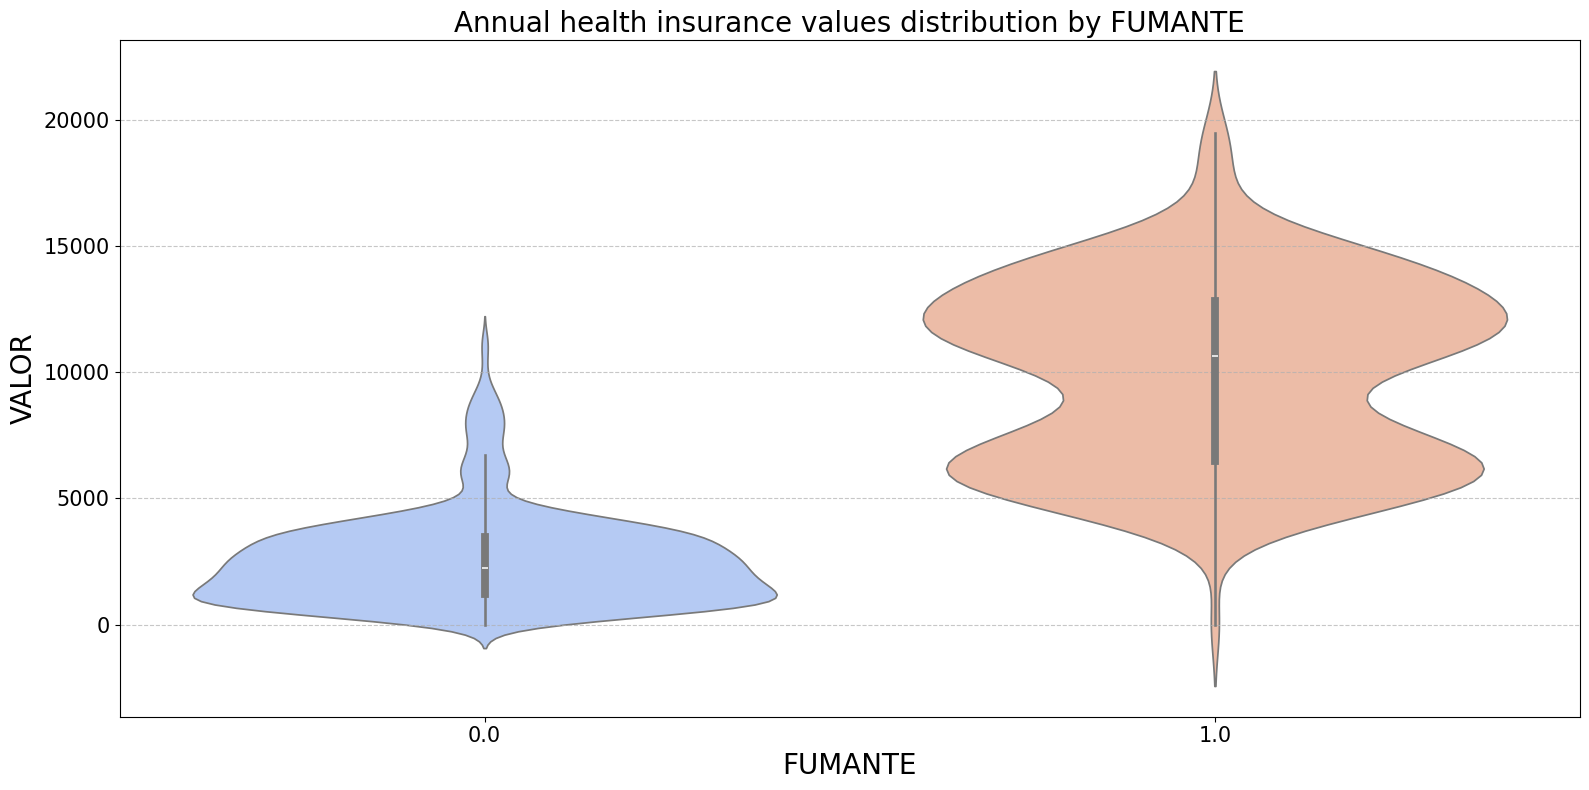

----------------------------------------------------------------------------------------------------


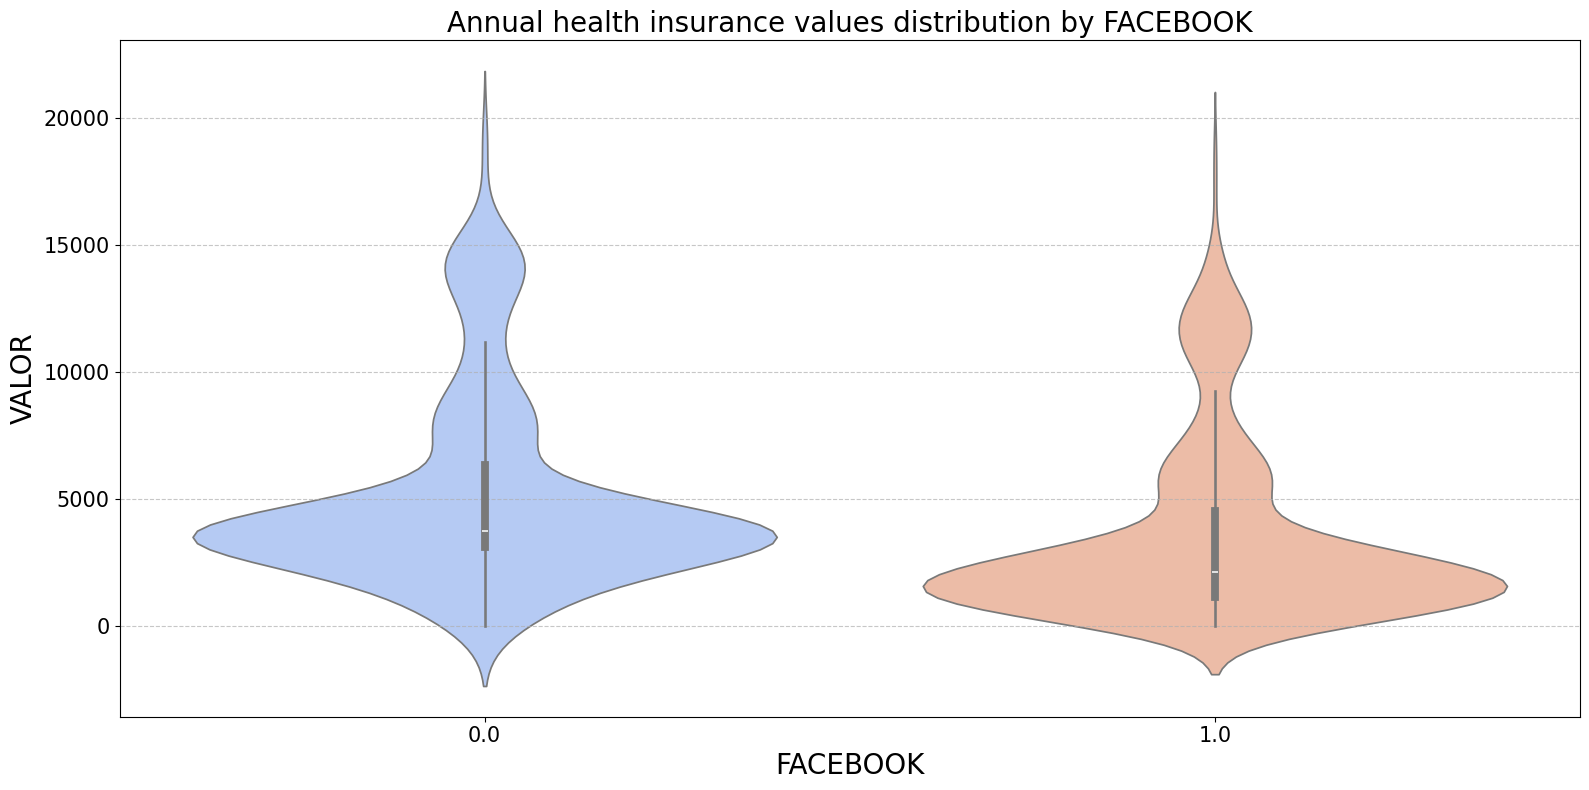

----------------------------------------------------------------------------------------------------


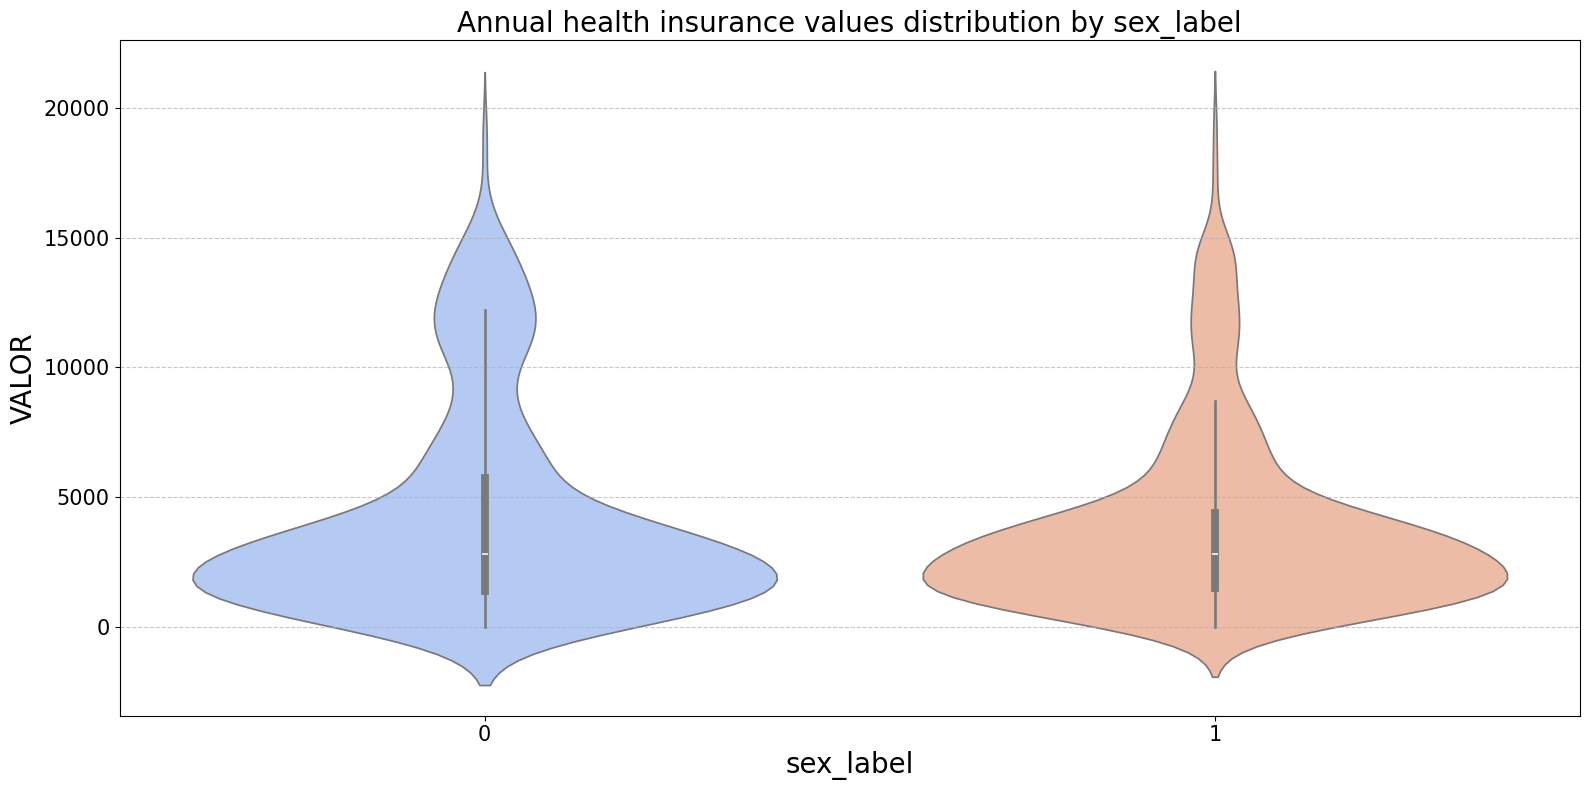

----------------------------------------------------------------------------------------------------


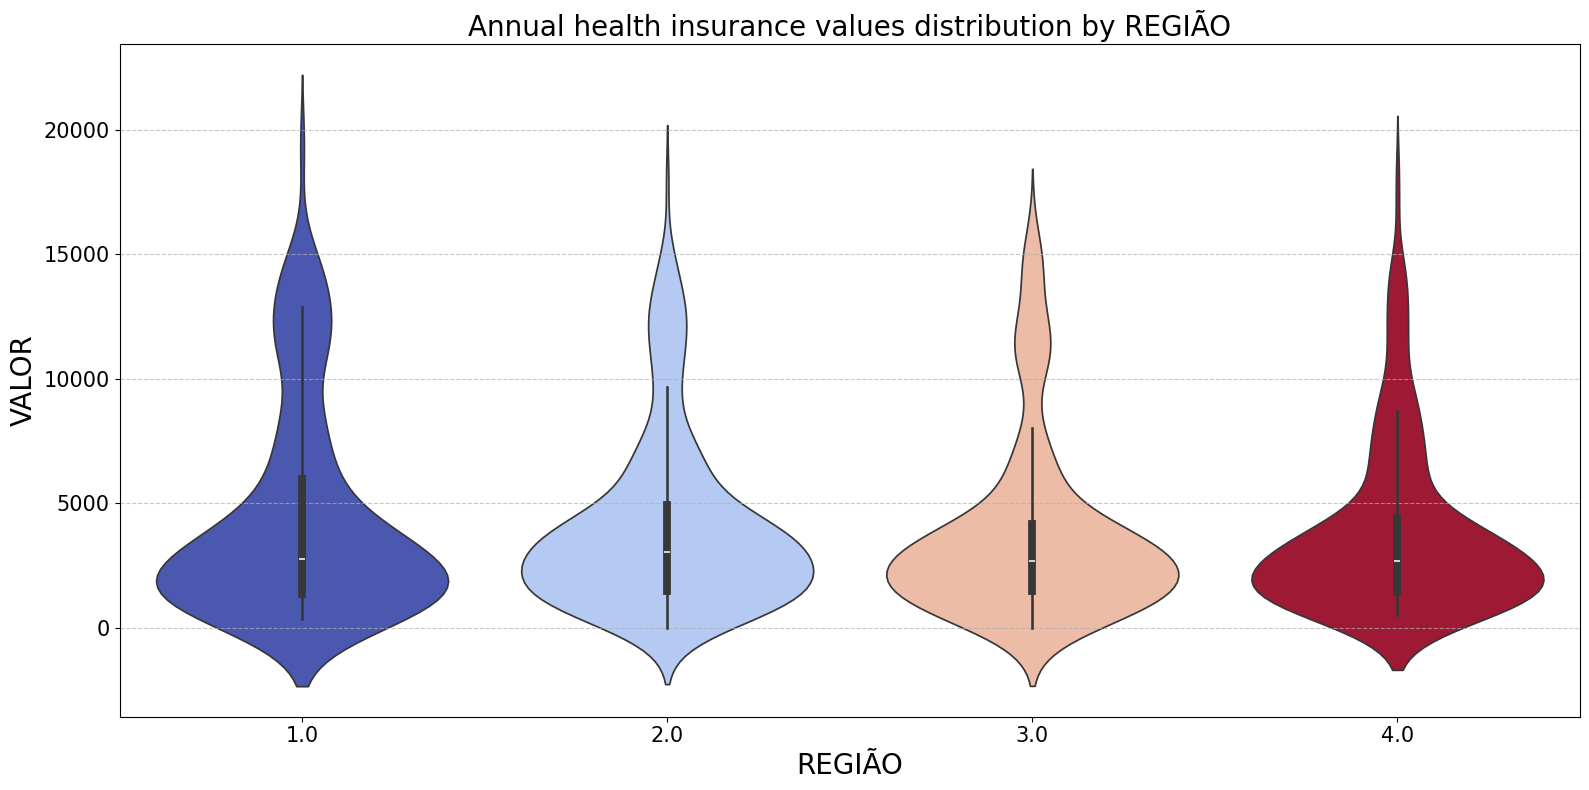

----------------------------------------------------------------------------------------------------


In [29]:
for nominal in nominals:
    plt.figure(figsize=(16, 8))
    sns.violinplot(x=nominal, y='VALOR', data=train_clean, palette='coolwarm', hue=nominal, legend=False)
    plt.xlabel(nominal, fontsize=20)
    plt.ylabel('VALOR', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f'Annual health insurance values distribution by {nominal}', fontsize=20)
    plt.tight_layout()
    plt.show()
    print('-'*100)

The quantitative and qualitative analysis from the Kruskal-Wallis (KW) test is as follows:  

- There are significant differences in `VALOR` between the groups based on `FUMANTE`.  
- Although the KW test detected distinctions in `VALOR` between the groups based on `FACEBOOK`, the distributions share a similar shape, with only a slight shift in the median.  
- No significant differences in `VALOR` were observed for groups based on `sex_label` or `REGIÃO`.  

# AutoML

In [30]:
from pycaret.regression import *

In [31]:
train_dataset = train_clean[
  best_mi_features + ['VALOR']
]

In [32]:
exp = setup(
  data=train_dataset,
  target='VALOR',
  train_size=0.8,
  normalize=True,
  categorical_features=['age_label', 'imc_label'] + nominals,
  numeric_features=numerical_features,
  remove_outliers=False,
  session_id=123
)

,Description,Value
0,Session id,123
1,Target,VALOR
2,Target type,Regression
3,Original data shape,"(1160, 10)"
4,Transformed data shape,"(1160, 21)"
5,Transformed train set shape,"(928, 21)"
6,Transformed test set shape,"(232, 21)"
7,Numeric features,3
8,Categorical features,6
9,Preprocess,True


In [33]:
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,818.5591,2159494.0558,1460.7288,0.8367,0.5718,0.3007,0.0320
rf,Random Forest Regressor,859.2989,2346633.2336,1522.3047,0.8220,0.6008,0.3396,0.0540
catboost,CatBoost Regressor,881.6648,2413339.6654,1541.4264,0.8190,0.5989,0.3365,0.2400
lightgbm,Light Gradient Boosting Machine,935.5584,2464806.7908,1563.3692,0.8094,0.6940,0.3960,0.3020
ada,AdaBoost Regressor,1361.8272,2778896.5407,1660.3956,0.7874,0.7513,0.7356,0.0180
et,Extra Trees Regressor,924.2798,2850898.6856,1679.1228,0.7832,0.6411,0.3640,0.0520
xgboost,Extreme Gradient Boosting,994.6416,3030695.6000,1725.3450,0.7682,0.6833,0.3985,0.0280
llar,Lasso Least Angle Regression,1308.2182,3543071.3833,1875.7393,0.7344,0.7307,0.4539,0.0160
br,Bayesian Ridge,1310.5775,3544165.9602,1875.9455,0.7344,0.7211,0.4553,0.0160
lasso,Lasso Regression,1308.2085,3543121.5360,1875.7521,0.7344,0.7312,0.4539,0.2140


In [34]:
gbr = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,837.8671,2624517.0435,1620.0361,0.7794,0.3948,0.2426
1,1061.3525,3533128.8763,1879.6619,0.7884,1.4849,0.3614
2,803.5566,2101614.6506,1449.6947,0.8800,0.4921,0.3796
3,636.9065,1344776.4384,1159.6450,0.8802,0.4230,0.2633
4,946.7169,2713879.1854,1647.3856,0.8089,0.4518,0.2828
5,759.1992,2115824.9090,1454.5875,0.8250,0.4146,0.2588
6,734.5626,1570891.6620,1253.3522,0.7681,0.4515,0.2853
7,773.0634,1594533.8729,1262.7485,0.8539,0.4873,0.4239
8,695.2882,1798305.0406,1341.0090,0.9030,0.3634,0.2571


In [35]:
tunned_gbr = tune_model(gbr, optimize='MSE', return_train_score=True, fold=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


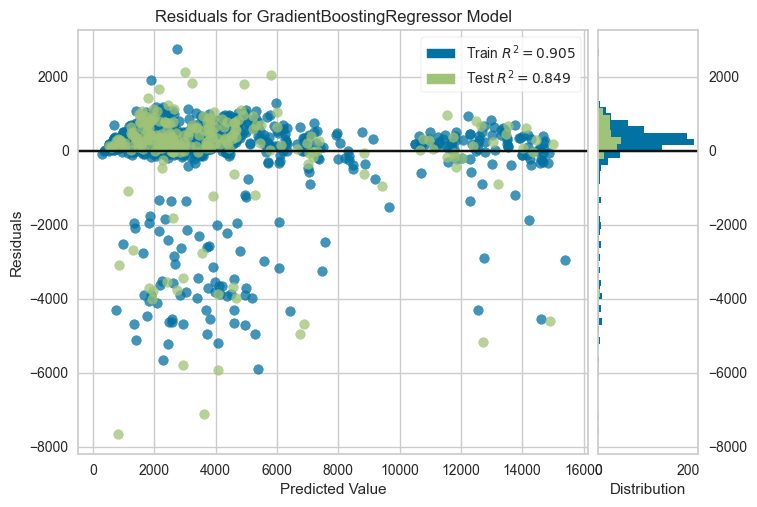

In [36]:
exp.plot_model(tunned_gbr)

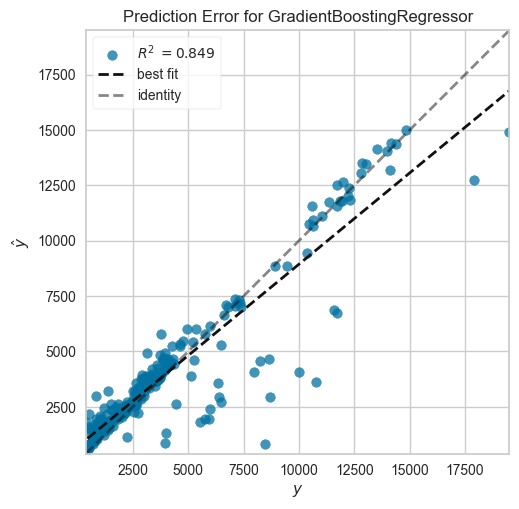

In [37]:
exp.plot_model(tunned_gbr, plot='error')

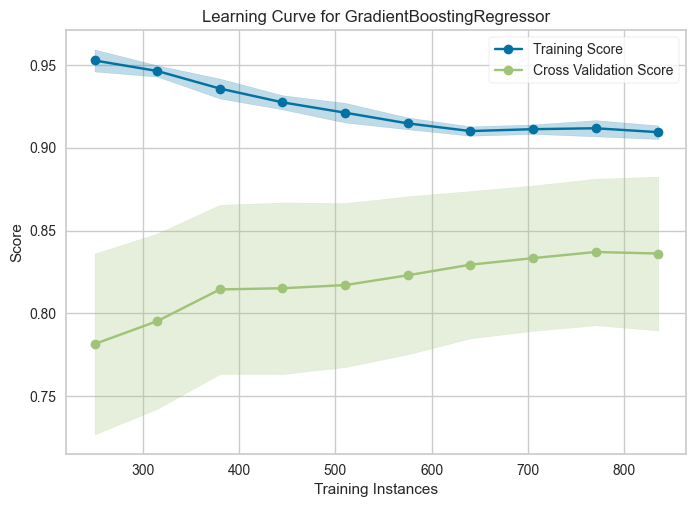

In [38]:
exp.plot_model(tunned_gbr, plot='learning')

Analyzing the learning curve:

* **Bias** (underfitting):

  - Training score around 0.95 indicates low bias
  - Good performance on training set shows no significant underfitting

* **Variance** (overfitting):

  - Notable gap between training (~0.95) and validation (~0.82) curves
  - This 0.13 point difference indicates high variance

Recommendation:
 - Increase the number of training instances to reduce the gap between train and validation

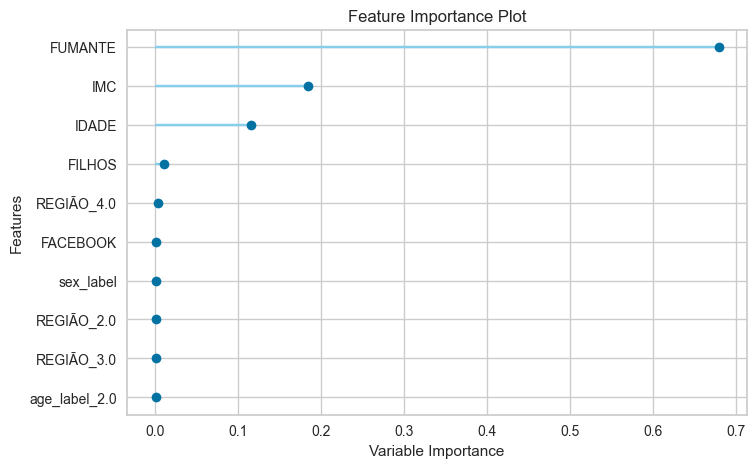

In [39]:
exp.plot_model(tunned_gbr, plot='feature')

The feature importance analysis confirmed the assumptions made during the Exploratory Data Analysis: `FUMANTE`, `IMC`, and `IDADE` were identified as key features. On the other hand, features like `FACEBOOK`, `REGIÃO`, and `sex_label` showed negligible importance.

## Blending models

We can attempt to mitigate the high variance by applying *blending* techniques with other models. Blending is an ensemble technique in machine learning that combines the predictions of multiple models to improve overall performance.

In [40]:
top3 = exp.compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,803.5994,2127736.6263,1443.9213,0.8369,0.5368,0.3043,0.0310
rf,Random Forest Regressor,843.1433,2311349.5023,1502.1066,0.8194,0.5632,0.3285,0.0570
catboost,CatBoost Regressor,861.2446,2366450.2677,1523.0047,0.8171,0.5718,0.3395,0.1490
lightgbm,Light Gradient Boosting Machine,920.3710,2386798.8447,1530.0181,0.8137,0.6227,0.3685,0.3400
ada,AdaBoost Regressor,1322.5301,2672430.2302,1625.6103,0.7913,0.7229,0.7309,0.0210
et,Extra Trees Regressor,908.9462,2810115.6130,1658.6583,0.7793,0.6042,0.3521,0.0510
xgboost,Extreme Gradient Boosting,982.9544,2874699.3500,1683.6014,0.7707,0.6540,0.4042,0.0260
br,Bayesian Ridge,1305.7277,3530981.2824,1869.9534,0.7294,0.6488,0.4536,0.0150
ridge,Ridge Regression,1304.8828,3531866.5606,1870.2672,0.7291,0.6534,0.4533,0.0170
llar,Lasso Least Angle Regression,1304.0065,3531817.1855,1870.2583,0.7291,0.6537,0.4525,0.0140


In [41]:
top3

[GradientBoostingRegressor(random_state=123),
 RandomForestRegressor(n_jobs=-1, random_state=123),

In [42]:
blender = exp.blend_models(estimator_list=top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,847.9793,2688807.9147,1639.7585,0.7740,0.3843,0.2314
1,1074.4014,3819907.1690,1954.4583,0.7713,1.4820,0.3662
2,802.2251,2019281.9453,1421.0144,0.8847,0.4779,0.3502
3,636.8020,1371009.9451,1170.9013,0.8778,0.4340,0.2744
4,909.8324,2653108.3806,1628.8365,0.8131,0.4480,0.2690
5,781.6344,2260694.9860,1503.5608,0.8130,0.4405,0.2704
6,809.0699,1750670.8617,1323.1292,0.7415,0.4794,0.3252
7,748.1884,1511818.7653,1229.5604,0.8615,0.4858,0.4343
8,755.9114,1761877.4092,1327.3573,0.9050,0.4048,0.3084


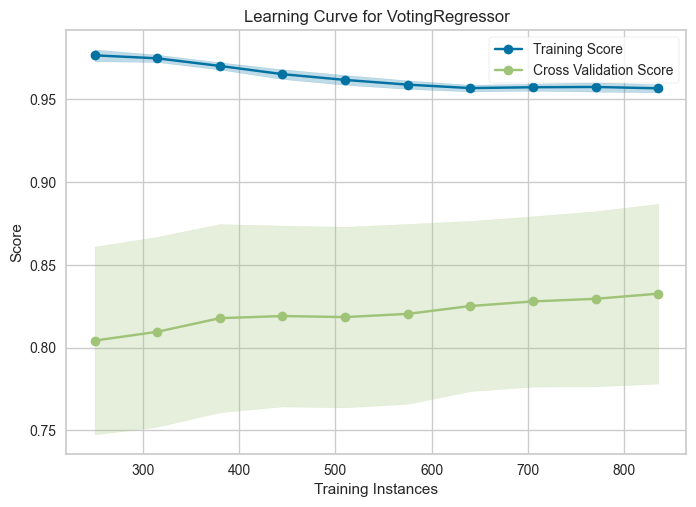

In [43]:
exp.plot_model(blender, plot='learning')

The gap between training and validation is still significant, which indicates that the variance is high (overfitting).

# Evaluation on unseen data

In [48]:
test['imc_class'] = test['IMC'].apply(lambda x: BMI(value=x).category if x >= 0 else None)
test['imc_label'] = test['imc_class'].apply(lambda x: bmi_str_to_label(x) if x else None)

test['age_class'] = test['IDADE'].apply(lambda x: AgeLevel(value=x).category if x >= 0 else None)
test['age_label'] = test['age_class'].apply(lambda x: age_str_to_label(x) if x else None)

test['signo_encoded'] = label_encoder.fit_transform(test['SIGNO'])
test['sex_label'] = test['SEXO'].apply(lambda x: 0 if x == 'M' else 1)

In [49]:
unseen_predictions = exp.predict_model(tunned_gbr, data=test[best_mi_features + ['VALOR']].dropna())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,795.9700,2352676.7092,1533.8438,0.8231,0.4405,0.2450
